# LAB 5 MOS: Optimización Multiobjetivo

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 1: Optimización Multiobjetivo en Distribución de Recursos para Misión Humanitaria

### Formulación del modelo Multiobjetivo

#### Conjuntos

$$ R = \{R_1,R_2,R_3,R_4,R_5\}$$
$$ A = \{A_1,A_2,A_3,A_4\}$$
$$ Z = \{Z_1,Z_2,Z_3,Z_4\}$$
$$ V = \{V_1,V_2\} $$

#### Parámetros

Recursos:

Valor de impacto (miles USD/TON):
$$ Va_r: \forall r \in R $$

Peso(TON/unidad):
$$ W_r: \forall r \in R$$

Volumen(m^3/unidad):
$$ V_r: \forall r \in R$$

Disponibilidad(unidades):
$$ D_r: \forall r \in R$$

Aviones:

Capacidad Peso (TON):
$$ CP_a: \forall a \in A$$

Capacidad Volumen (m^3):
$$ CV_a: \forall a \in A$$

Costo Fijo (miles UDS):
$$ CF_a: \forall a \in A$$

Costo Variable (miles UDS/km):
$$ C_a: \forall a \in A$$

Zonas:

Distancias (km):
$$ D_z: \forall z \in Z$$

Poblacion (miles):
$$ P_z: \forall z \in Z$$

Multiplicador:
$$ M_z: \forall z \in Z$$

Demanda de recurso por zona (TON):
$$ D_{r,z,v}: \forall r \in R, \forall z \in Z $$

#### Variables de decision

Asignación de aviones a zonas:

$$ x_{a,z,v} \in N, \forall a \in A, \forall z \in Z, \forall v \in V $$

Asignación de recursos a aviones:

$$ y_{a,r,v} \in N, \forall a \in A, \forall r \in R, \forall V \in V $$

#### Funciones objetivo

Maximizar Impacto social:
$$ Z_1 = \sum_{r\in R} \sum_{a\in A} \sum_{v\in V} \sum_{z\in Z} Va_r \cdot y_{a,r,v} \cdot M_z $$

Minimizar Costo de tranporte:
$$ Z_2 = \sum_{a\in A} \sum_{z\in Z} \sum_{v\in V} CF_a \cdot x_{a,z,v} + \sum_{v\in V} \sum_{z\in Z} \sum_{a\in A} C_a \cdot x_{a,z,v} \cdot D_z $$


#### Restricciones

Capacidad de peso y volumen de los aviones:
$$ \sum_{r\in R} \sum_{v\in V} y_{a,r,v} \cdot W_r \leq CP_a, \forall a \in A $$
$$ \sum_{r\in R} \sum_{v\in V} y_{a,r,v} \cdot V_r \leq CV_a, \forall a \in A $$

Asignacion de recursos no sobrepase la disponibilidad:
$$ \sum_{a\in A} \sum_{v\in V} y_{a,r,v} \leq D_r, \forall r \in R $$

Seguridad de los medicamentos:
$$ y_{1,medicamento,v} = 0, \forall v \in V $$

Compatibilidad de recursos:
$$ | y_{a,medicamentos,v} + y_{a,agua,v} | =  | y_{a,medicamentos,v} - y_{a,agua,v} |, \forall a \in A, \forall v \in V $$

Asignacion de zonas por avion y viaje (el avion solo puede ir una vez a una zona):
$$ \sum_{z\in Z} \sum_{v\in V} x_{a,z,v} \leq 1, \forall a \in A $$

Satisfaccion de necesidades:
$$ \sum_{a\in A} \sum_{v\in V} y_{a,r,v} \geq D_z, \forall z \in Z, \forall r \in R $$

Solo lleva recursos si va a la zona:
$$ x_{a,z,v} \cdot BigM \geq \sum_{r \in R} y_{a,r,v}, \forall z \in Z, \forall v \in V, \forall a \in A $$

No negatividad y binaria:
$$ x_{a,z,v} \in {0,1} $$
$$ y_{a,r,v} \geq 0  \in N$$

#### Modelo de optimización


### Implementación del modelo

In [5]:
recursos = ['alimentos', 'medicinas', 'equipo_medico', 'agua', 'mantas'] 
aviones = ['A1', 'A2', 'A3', 'A4']  
zonas = ['A','B','C','D']
viajes = ['V1', 'V2']

datos_recursos = {
    'alimentos': {'valor': 50, 'peso': 5, 'volumen': 3, 'disponibilidad': 100}, #12
    'medicinas': {'valor': 100, 'peso': 2, 'volumen': 1, 'disponibilidad': 150}, #15
    'equipo_medico': {'valor': 120, 'peso': 0.3, 'volumen': 0.5, 'disponibilidad': 200}, #40
    'agua': {'valor': 60, 'peso': 6, 'volumen': 4, 'disponibilidad': 150}, #15
    'mantas': {'valor': 40, 'peso': 3, 'volumen': 2, 'disponibilidad': 200}, #20
}

datos_aviones = {
    'A1': {'peso_max': 40, 'volumen_max': 35, 'costo_fijo': 15, 'costo_variable': 0.020},
    'A2': {'peso_max': 50, 'volumen_max': 40, 'costo_fijo': 20, 'costo_variable': 0.025},
    'A3': {'peso_max': 60, 'volumen_max': 45, 'costo_fijo': 25, 'costo_variable': 0.030},
    'A4': {'peso_max': 45, 'volumen_max': 38, 'costo_fijo': 18, 'costo_variable': 0.022}
}

datos_zonas = {
    'A': {'distancia': 800, 'poblacion': 50, 'multiplicador': 1.2},
    'B': {'distancia': 1200, 'poblacion': 70, 'multiplicador': 1.5},
    'C': {'distancia': 1500, 'poblacion': 100, 'multiplicador': 1.8},
    'D': {'distancia': 900, 'poblacion': 80, 'multiplicador': 1.4}
}

# toneladas (es necesario tratarlas como unidades)
necesidades_minimas = {
    'A': {'alimentos': 8, 'agua': 6, 'medicinas': 2, 'equipo_medico': 0.6, 'mantas': 3},
    'B': {'alimentos': 12, 'agua': 9, 'medicinas': 3, 'equipo_medico': 0.9, 'mantas': 5},
    'C': {'alimentos': 16, 'agua': 12, 'medicinas': 4, 'equipo_medico': 1.2, 'mantas': 7},
    'D': {'alimentos': 10, 'agua': 8, 'medicinas': 2, 'equipo_medico': 0.6, 'mantas': 4}
}

In [6]:
from pyomo.environ import *
import numpy as np

# Crear un modelo
model = ConcreteModel()

# Conjuntos
model.R = Set(initialize=recursos)
model.A = Set(initialize=aviones)
model.Z = Set(initialize=zonas)
model.V = Set(initialize=viajes)

# Parámetros
model.Va = Param(model.R, initialize={r: datos_recursos[r]['valor'] for r in recursos})
model.W = Param(model.R, initialize={r: datos_recursos[r]['peso'] for r in recursos})
model.V_r = Param(model.R, initialize={r: datos_recursos[r]['volumen'] for r in recursos})
model.D_r = Param(model.R, initialize={r: datos_recursos[r]['disponibilidad'] for r in recursos})

model.CP = Param(model.A, initialize={a: datos_aviones[a]['peso_max'] for a in aviones})
model.CV = Param(model.A, initialize={a: datos_aviones[a]['volumen_max'] for a in aviones})
model.CF = Param(model.A, initialize={a: datos_aviones[a]['costo_fijo'] for a in aviones})
model.C = Param(model.A, initialize={a: datos_aviones[a]['costo_variable'] for a in aviones})

model.D_z = Param(model.Z, initialize={z: datos_zonas[z]['distancia'] for z in zonas})
model.M_z = Param(model.Z, initialize={z: datos_zonas[z]['multiplicador'] for z in zonas})
model.N = Param(model.Z, model.R, initialize={(z, r): necesidades_minimas[z][r] for z in zonas for r in recursos})

# Epsilon
model.epsilon = Param(mutable=True, initialize=1e6)

# Variables de decisión
model.x = Var(model.A, model.Z, model.V, within=Binary)  # Asignación de aviones a zonas por viaje
model.y = Var(model.A, model.Z, model.R, model.V, within=NonNegativeReals)  # Cantidad de recursos transportados por avión
model.z = Var(model.A, model.V, within=Binary)  # Determina si el avion a en el viaje v lleva medicamentos

# Función Objetivo 1: Maximizar impacto social

def impacto_social(model):
    return sum(model.Va[r] * model.y[a, z, r, v] * model.M_z[z]
               for a in model.A for z in model.Z for r in model.R for v in model.V)
model.obj = Objective(rule=impacto_social, sense=maximize)

# Función Objetivo 2: Minimizar costo de transporte (Como expresion)

def costo_transporte(model):
    return sum(model.CF[a] * model.x[a, z, v] 
               + model.C[a] * model.D_z[z] * model.x[a, z, v]
               for a in model.A for z in model.Z for v in model.V)
model.costo_total = Expression(rule=costo_transporte)

# e-constraint
model.epsilon_constraint = Constraint(expr=model.costo_total <= model.epsilon)

# --- Restricciones ---

# Restricción de capacidad de peso y volumen de los aviones

def restr_capacidad_peso(m, a, v):
    return sum(m.y[a, z, r, v] * m.W[r] 
               for z in m.Z for r in m.R) <= m.CP[a]
model.restr_capacidad_peso = Constraint(model.A, model.V, rule=restr_capacidad_peso)

def restr_capacidad_volumen(m, a, v):
    return sum(m.y[a, z, r, v] * m.V_r[r] 
               for z in m.Z for r in m.R) <= m.CV[a]
model.restr_capacidad_volumen = Constraint(model.A, model.V, rule=restr_capacidad_volumen)

# Restricción de disponibilidad de los recursos TODO
#def restriccion_disponibilidad(model, r):
    #return sum(model.y[a, r, v] for a in model.A for v in model.V) <= model.D_r[r]
#model.restriccion_disponibilidad = Constraint(model.R, rule=restriccion_disponibilidad)

def restr_disponibilidad(m, r):
    return sum(m.y[a, z, r, v] for a in m.A for z in m.Z for v in m.V) <= m.D_r[r]
model.restr_disponibilidad = Constraint(model.R, rule=restr_disponibilidad)

# Restricción de seguridad de los medicamentos (medicinas no se pueden transportar en el avión A1)
def restriccion_medicinas(model, v, z):
    return model.y['A1', z,'medicinas', v] == 0
model.restriccion_medicinas = Constraint(model.V, model.Z,rule=restriccion_medicinas)

M = 1e5
# Si transporta agua, no puede transportar medicinas
def restriccion_agua_z(model, a, v):
    return sum(model.y[a, z,'agua', v] for z in model.Z) <= (1 - model.z[a, v]) * M
model.restriccion_agua_z = Constraint(model.A, model.V, rule=restriccion_agua_z)

# Si transporta medicinas, no puede transportar agua
def restriccion_medicinas_z(model, a, v):
    return sum(model.y[a,z , 'medicinas', v] for z in model.Z) <= model.z[a, v] * M
model.restriccion_medicinas_z = Constraint(model.A, model.V, rule=restriccion_medicinas_z)

# Restricción de asignación de zona unica por vuelo
def restriccion_zona_unica(model, a, v):
    return sum(model.x[a, z, v] for z in model.Z) <= 1
model.restriccion_zona_unica = Constraint(model.A, model.V,rule=restriccion_zona_unica)

# Restricción de no repetir zona
def restriccion_zona_viaje(model, a, z):
    return model.x[a, z, 'V1'] + model.x[a, z, 'V2'] <= 1
model.restriccion_zona_viaje = Constraint(model.A, model.Z,rule=restriccion_zona_viaje)

# Restricción de satisfacción de las necesidades mínimas TODO

def restr_necesidades(m, z, r):
    return sum(m.y[a, z, r, v] * m.W[r] for a in m.A for v in m.V) >= m.N[z, r]
model.restr_necesidades = Constraint(model.Z, model.R, rule=restr_necesidades)

# Restricción de transporte solo si el avión va a la zona (vinculo x-y)
def vinculo_y_x(m, a, z, r, v):
    return m.y[a, z, r, v] <= M * m.x[a, z, v]
model.vinculo_y_x = Constraint(model.A, model.Z, model.R, model.V, rule=vinculo_y_x)



In [7]:
# Correr el modelo para diferentes valores de epsilon
import matplotlib.pyplot as plt
from tabulate import tabulate

solver = SolverFactory('glpk')


def mostrar_viajes(m, epsilon, impacto, costo):
    print(f"\n=== Solución para ε = {epsilon:.2f} ===")
    print(f"Impacto Social: {impacto:.2f}")
    print(f"Costo Total: {costo:.2f}\n")

    for a in m.A:
        for z in m.Z:
            for v in m.V:
                if m.x[a, z, v].value > 0.5:
                    recursos_viaje = []
                    for r in m.R:
                        qty = m.y[a, z, r, v].value
                        if qty > 0.5:  # Solo mostrar si lleva algo
                            recursos_viaje.append([r, qty])
                    if recursos_viaje:
                        print(f"🚀 En el viaje {v} del avión {a} hacia la zona {z}, se lleva:")
                        print(tabulate(recursos_viaje, headers=["Recurso", "Unidades"], tablefmt="fancy_grid", floatfmt=".1f"))
                        print("\n" + "-"*60 + "\n")

# Primero obtenemos el costo mínimo (ideal)

model.obj.deactivate()
model_min = Objective(expr=model.costo_total, sense=minimize)
model.add_component('min_obj', model_min)
res1 = solver.solve(model)
costo_min = model.costo_total()
print("Limite inferior de e encontrado")

# Y el costo máximo permitiendo máximo impacto social
model.del_component('min_obj')
model.obj.activate()
res2 = solver.solve(model)
costo_max = model.costo_total()
print("Limite superior de e encontrado")

# Definimos valores de epsilon (entre el mínimo y el máximo)
epsilons = np.linspace(costo_min, costo_max, 7)

# Guardamos resultados
impactos = []
costos = []
print("Iniciando a hallar los valores para el frente")
for eps in epsilons:
    model.epsilon = eps
    resultado = solver.solve(model)
    impacto = model.obj()
    costo = model.costo_total()
    if (impacto_social(model)() > 0):
        mostrar_viajes(model, eps, impacto, costo)
    impactos.append(impacto)
    costos.append(costo)


Limite inferior de e encontrado
Limite superior de e encontrado
Iniciando a hallar los valores para el frente

=== Solución para ε = 362.90 ===
Impacto Social: 53019.67
Costo Total: 362.90

🚀 En el viaje V2 del avión A1 hacia la zona B, se lleva:
╒═══════════════╤════════════╕
│ Recurso       │   Unidades │
╞═══════════════╪════════════╡
│ alimentos     │        2.4 │
├───────────────┼────────────┤
│ equipo_medico │       36.9 │
├───────────────┼────────────┤
│ agua          │        1.5 │
├───────────────┼────────────┤
│ mantas        │        1.7 │
╘═══════════════╧════════════╛

------------------------------------------------------------

🚀 En el viaje V1 del avión A1 hacia la zona C, se lleva:
╒═══════════════╤════════════╕
│ Recurso       │   Unidades │
╞═══════════════╪════════════╡
│ alimentos     │        3.2 │
├───────────────┼────────────┤
│ equipo_medico │       31.3 │
├───────────────┼────────────┤
│ agua          │        2.0 │
├───────────────┼────────────┤
│ mantas     

#### Visualizacion del frente de Pareto

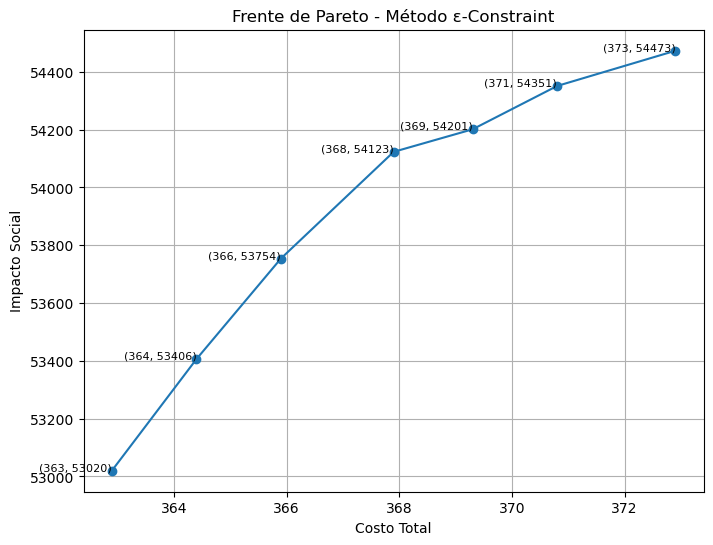

In [8]:
# Graficamos el frente de Pareto con etiquetas en los puntos
plt.figure(figsize=(8,6))
plt.plot(costos, impactos, marker='o')

for i in range(len(costos)):
    plt.text(costos[i], impactos[i], f"({costos[i]:.0f}, {impactos[i]:.0f})", fontsize=8, ha='right')

plt.xlabel('Costo Total')
plt.ylabel('Impacto Social')
plt.title('Frente de Pareto - Método ε-Constraint')
plt.grid(True)
plt.show()

### Analisis

## Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

### Formulación del modelo Multiobjetivo

#### Conjuntos

#### Parámetros

#### Variables de decision

#### Funciones objetivo

#### Restricciones

### Modelo de optimización


### Implementación del modelo

In [9]:
#codigo

#### Visulizacion del frente de Pareto

In [10]:
#codigo

### Analisis